<h3>NLP Tutorial: Text Classification Using Spacy Word Embeddings</h3>

Importing data

In [1]:
import pandas as pd

df = pd.read_csv(r"./Fake_Real_Data.csv")
print(df.shape)
df.head(5)

(9900, 2)


,Text,label
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake
1,U.S. conservative leader optimistic of common ...,Real
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real
3,Court Forces Ohio To Allow Millions Of Illega...,Fake
4,Democrats say Trump agrees to work on immigrat...,Real


Checking label distribution. We can see that the labels (classes) occur in nearly equal proportions, indicating a balanced dataset. There is no problem of class imbalance and hence no need to apply any balancing techniques like undersampling, oversampling etc.

In [2]:
df['label'].value_counts()

label
Fake    5000
Real    4900
Name: count, dtype: int64

Label Encoding for numeric target variable

In [3]:
df['label_num'] = df['label'].map({'Fake' : 0, 'Real': 1})
df.head(5)

,Text,label,label_num
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0
1,U.S. conservative leader optimistic of common ...,Real,1
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0
4,Democrats say Trump agrees to work on immigrat...,Real,1


Loading spaCy large model, getting the text vector and storing them as a new column.

In [4]:
import spacy
nlp = spacy.load("en_core_web_lg")
#This will nearly 15 minutes
df['vector'] = df['Text'].apply(lambda text: nlp(text).vector)  
display(df.head()) 

,Text,label,label_num,vector
0,Top Trump Surrogate BRUTALLY Stabs Him In The...,Fake,0,"[-0.6759837, 1.4263071, -2.318466, -0.451093, ..."
1,U.S. conservative leader optimistic of common ...,Real,1,"[-1.8355803, 1.3101058, -2.4919677, 1.0268308,..."
2,"Trump proposes U.S. tax overhaul, stirs concer...",Real,1,"[-1.9851209, 0.14389805, -2.4221718, 0.9133005..."
3,Court Forces Ohio To Allow Millions Of Illega...,Fake,0,"[-2.7812982, -0.16120885, -1.609772, 1.3624227..."
4,Democrats say Trump agrees to work on immigrat...,Real,1,"[-2.2010763, 0.9961637, -2.4088492, 1.128273, ..."


Splitting into 80-20 train and test. No stratifying is needed due to target balanced classes.
Converting into 2D numpy arrays for Models input.

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(df['vector'].values, df['label_num'], test_size=0.2, random_state=555)
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)
print(X_train_2d.shape, X_test_2d.shape)

(7920, 300) (1980, 300)


Training and evaluating the **Multinomial Naive Bayes** classifier.  
We need to perform Min-Max scaling because this model does not accept negative values.

In [6]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report

scaler = MinMaxScaler()
scaled_train_embed = scaler.fit_transform(X_train_2d)
scaled_test_embed = scaler.transform(X_test_2d)

mnb = MultinomialNB()
mnb.fit(scaled_train_embed, y_train)
y_pred_mnb = mnb.predict(scaled_test_embed)

print(classification_report(y_test, y_pred_mnb))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      1033
           1       0.95      0.96      0.95       947

    accuracy                           0.96      1980
   macro avg       0.95      0.96      0.95      1980
weighted avg       0.96      0.96      0.96      1980



Training and evaluating the **K-Nearest Neighbors** classifier.  

In [8]:
from  sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors = 5, metric = 'euclidean')
knn.fit(X_train_2d, y_train)
y_pred_knn = knn.predict(X_test_2d)

print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1033
           1       0.99      1.00      0.99       947

    accuracy                           0.99      1980
   macro avg       0.99      0.99      0.99      1980
weighted avg       0.99      0.99      0.99      1980



Displaying **Confusion Matrix** for best model with Seaborn's HeatMap.

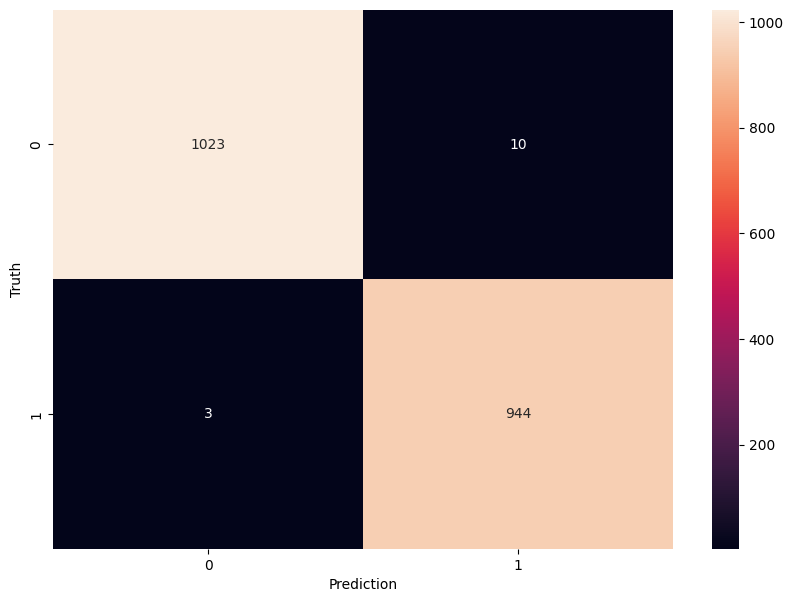

In [9]:
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
import seaborn as sn

cm = confusion_matrix(y_test, y_pred_knn)

plt.figure(figsize = (10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

#### Conclusion

1. KNN model performed really well with glove vectors due to only **300-dimensional** vectors and very good embeddings(similar and related words have almost similar embeddings) for the given text data.  
This model probably will not perform well in vectorization techniques like Bag of words and TF-IDF due to very **high dimensional vector space**.

2. MultinomialNB model performed decently well. However we have negative values present in the 300-dimensional vectors. The Naive Bayes model does not fit the data if there are **negative values**.  
So, to overcome this shortcoming, we have used the **Min-Max scaler** to bring down all the values between 0 to 1. In this process, there will be a possibility of variance and information loss among the data. But we got a decent scores.